In [1]:
%load_ext autoreload
%autoreload 2

Add the autoreload command so that changes made on the forestplot library can be reflected automatically

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import forestplot as fp
# Please use the version of forestplot found in my repository:
# https://github.com/takua624/forestplot
# I'm trying to tweak the original version (https://github.com/lsys/forestplot) to do what we want to do in the MEP

## Example Data

https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD014624.pub2/full

Wilson et al. (2025) Brexanolone, zuranolone and related neurosteroid GABAA receptor positive allosteric modulators for postnatal depression

In [3]:
# an example of the weighted total calculation using Mantel-Haenszel random-effects model
# CD014624 analysis 2.1, subgroup 2

x1 = 49
xN1 = 77
x2 = 47
xN2 = 98

y1 = 33
yN1 = 76
y2 = 24
yN2 = 98

w1 = 0.603
w2 = 0.397
e1 = 1.47
e2 = 1.96

rx1 = x1/xN1
rx2 = x2/xN2
ry1 = y1/yN1
ry2 = y2/yN2

logr1 = np.log(rx1/ry1)
logr2 = np.log(rx2/ry2)
ans = np.exp(w1*logr1 + w2*logr2) # THIS IS IT!!

print(ans)

1.6442960216275762


In [4]:
data_dir = "forest_plot_practice"
data_package_dir = "CD014624"
data_package_ID = data_package_dir.split("-")[0]
# CD014624, CD006475-SUP-08

df = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-data-rows.csv")
est = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-overall-estimates-and-settings.csv")
est_g = pd.read_csv(f"{data_dir}/{data_package_dir}-dataPackage/{data_package_ID}-analysis-data/{data_package_ID}-subgroup-estimates.csv")

est_cols = est.columns
est_g_cols = est_g.columns
common_cols = [cc for cc in est_cols if cc in est_g_cols]
print(common_cols)


['Analysis group', 'Analysis number', 'Experimental cases', 'Experimental N', 'Control cases', 'Control N', 'Mean', 'CI start', 'CI end', 'Heterogeneity Tau²', 'Tau² CI start', 'Tau² CI end', 'Heterogeneity Chi²', 'Heterogeneity df', 'Heterogeneity P', 'Heterogeneity I²', 'Effect Z', 'Effect T', 'Effect P', 'ID']


Group: 1, Analysis: 1
... Subgroup 1.0


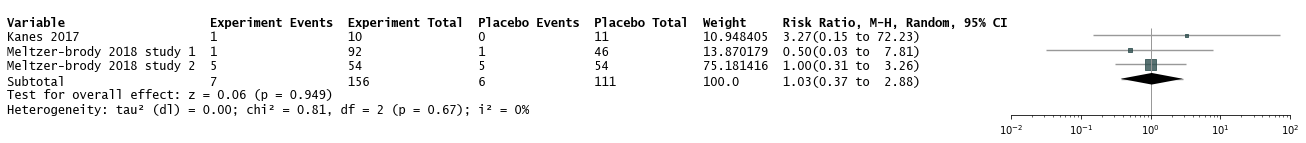

... Subgroup 2.0


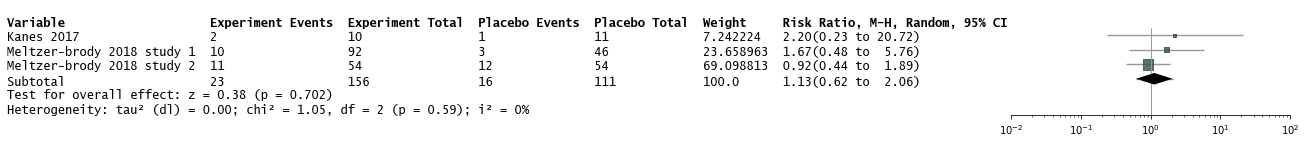

... Subgroup 3.0


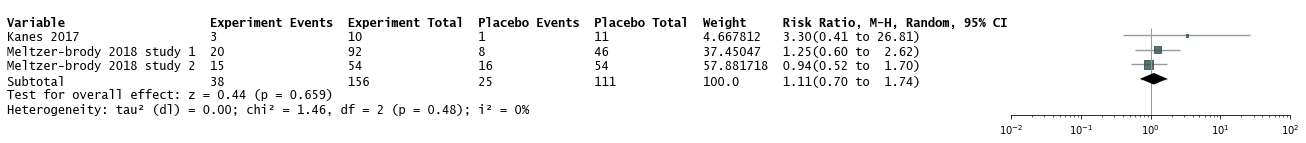

... Subgroup 4.0


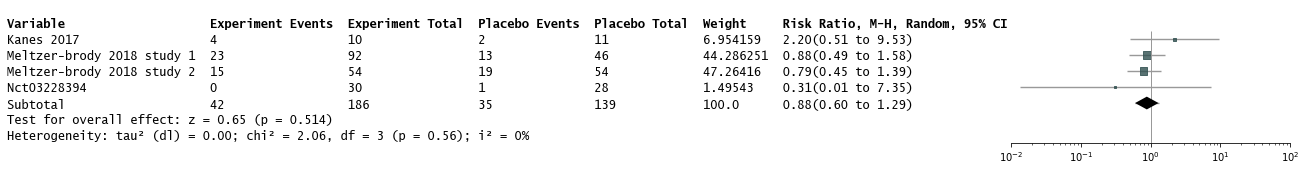

... Subgroup 5.0


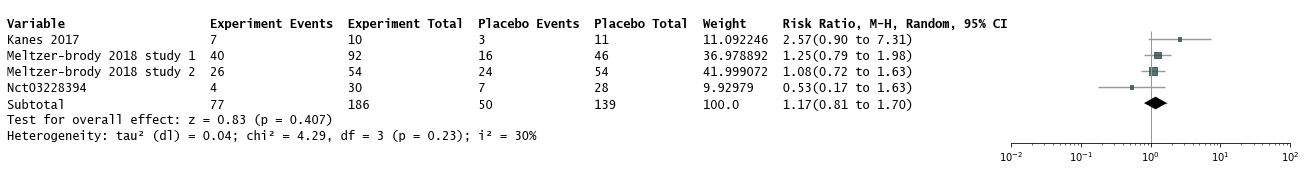

... Subgroup 6.0


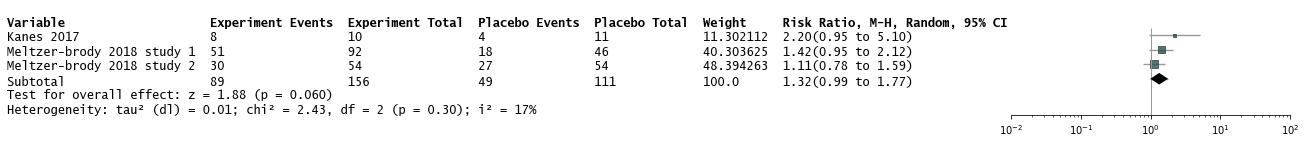

... Subgroup 7.0


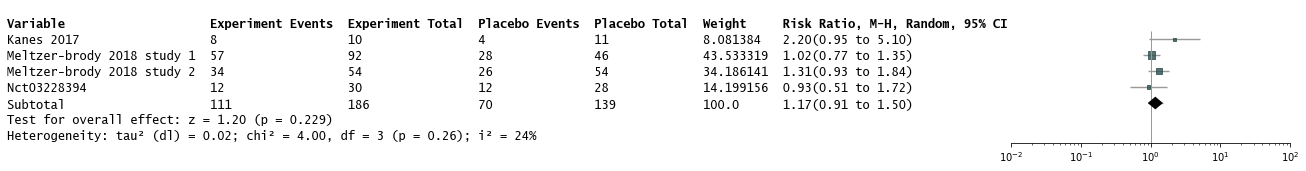

... Subgroup 8.0


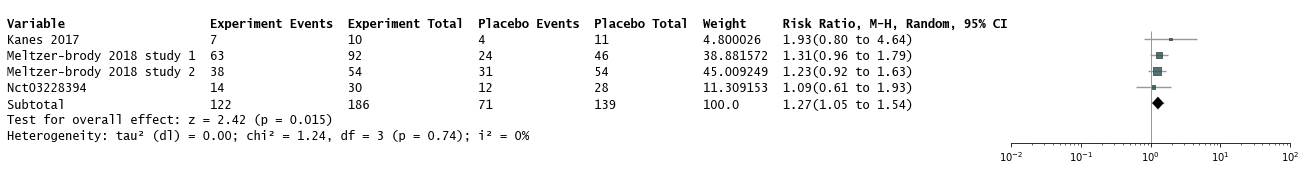

... Subgroup 9.0


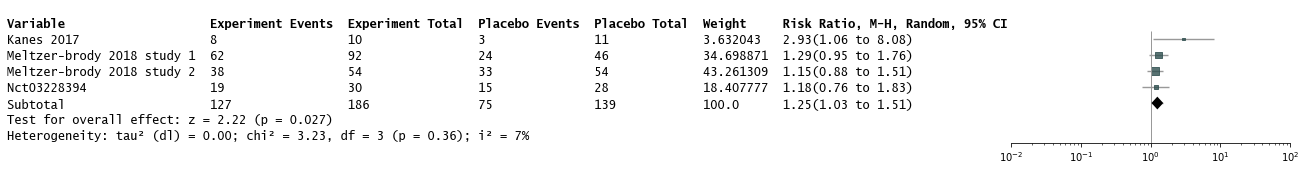

... Subgroup 10.0


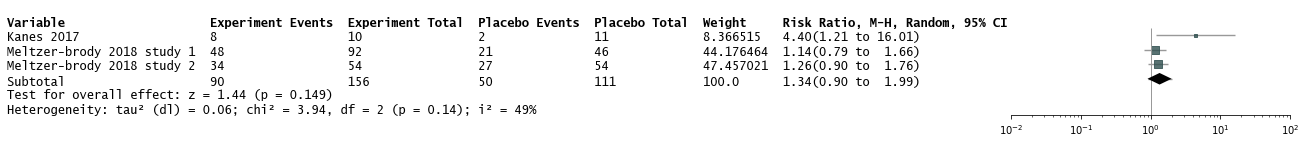

... Subgroup 11.0


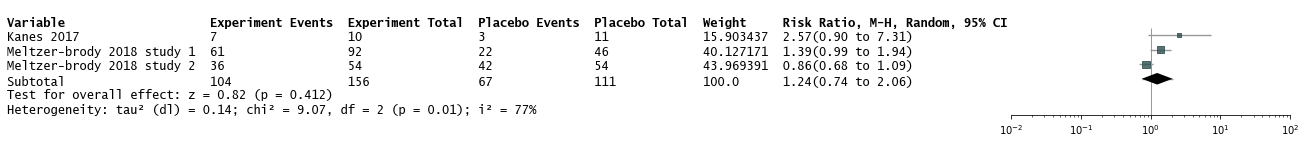

Group: 1, Analysis: 2
... Subgroup 1.0


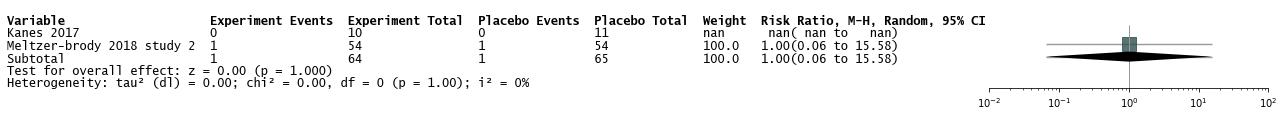

... Subgroup 2.0


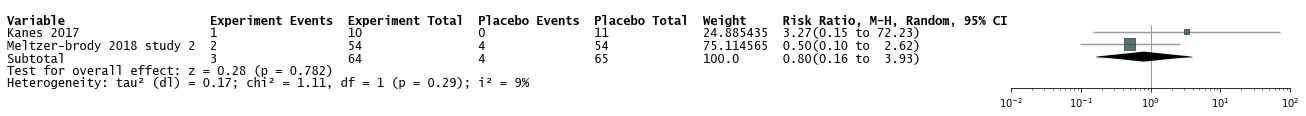

... Subgroup 3.0


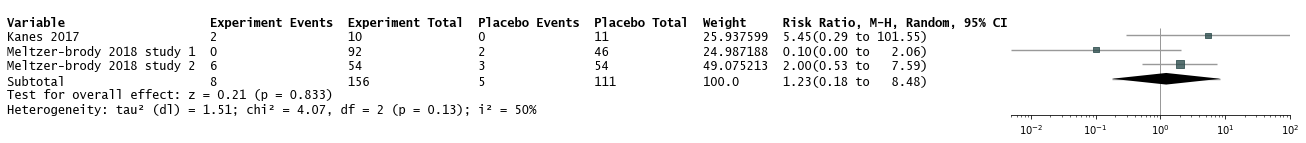

... Subgroup 4.0


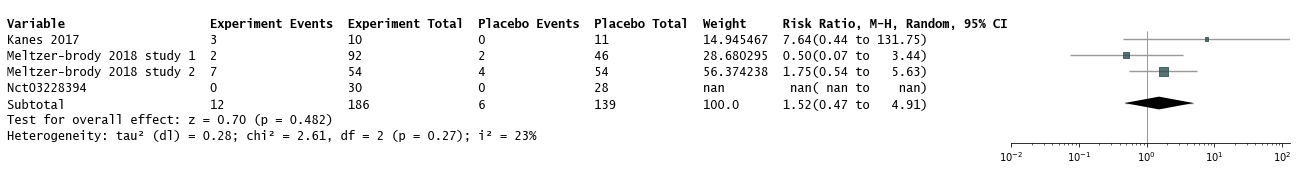

... Subgroup 5.0


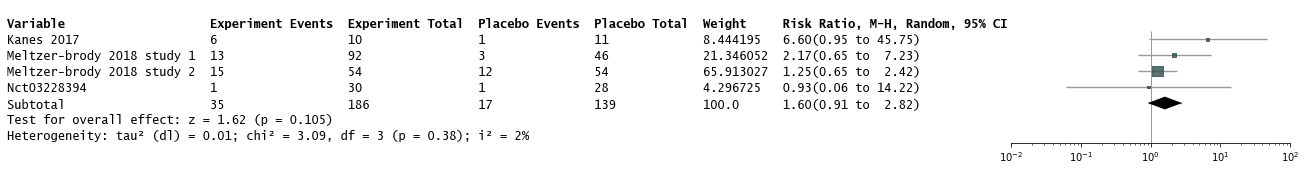

... Subgroup 6.0


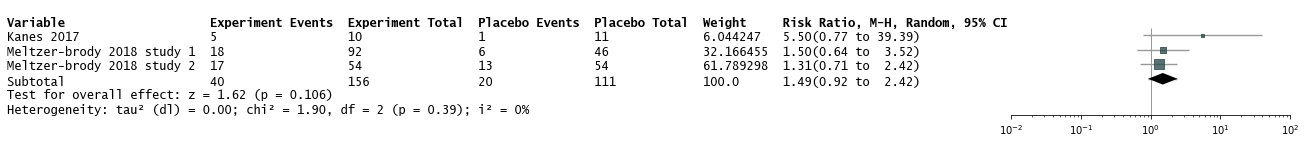

... Subgroup 7.0


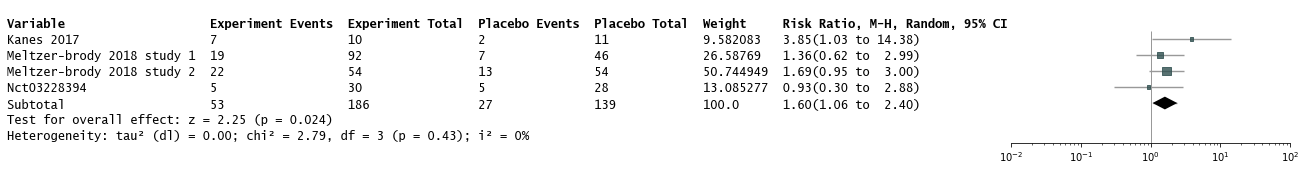

... Subgroup 8.0


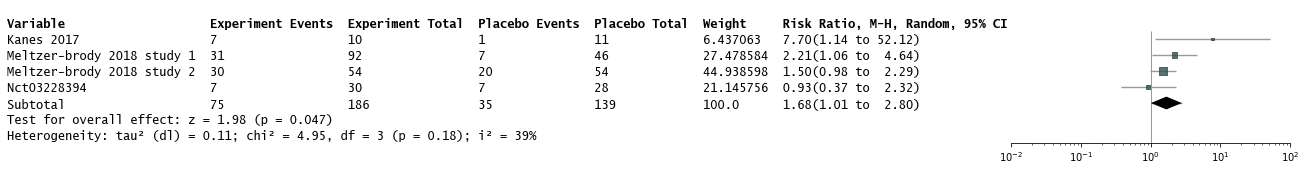

... Subgroup 9.0


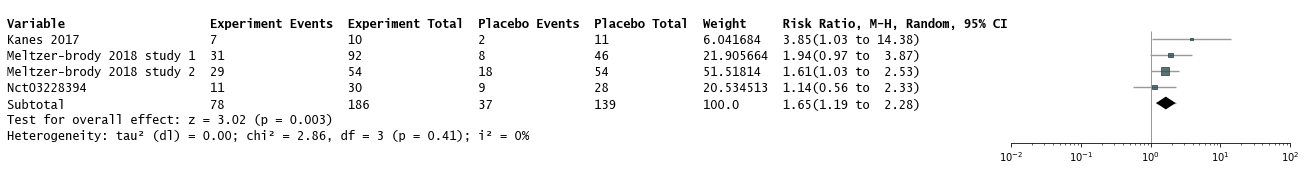

... Subgroup 10.0


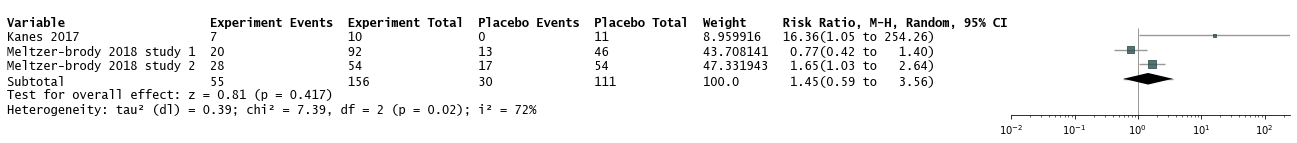

... Subgroup 11.0


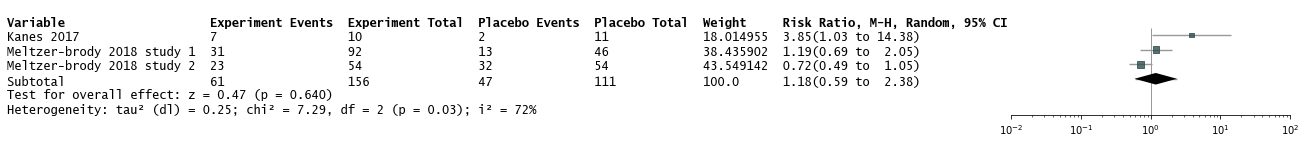

Group: 1, Analysis: 3
... Subgroup 1.0


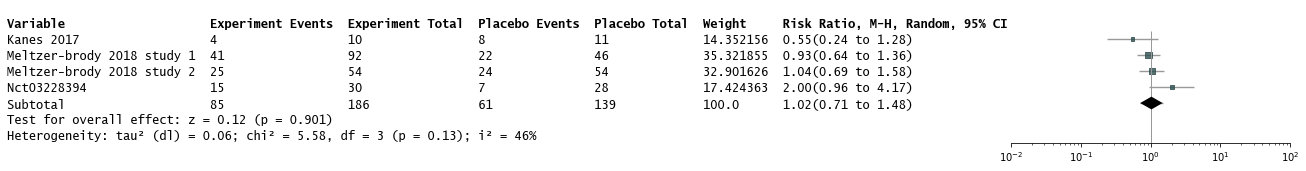

... Subgroup 2.0


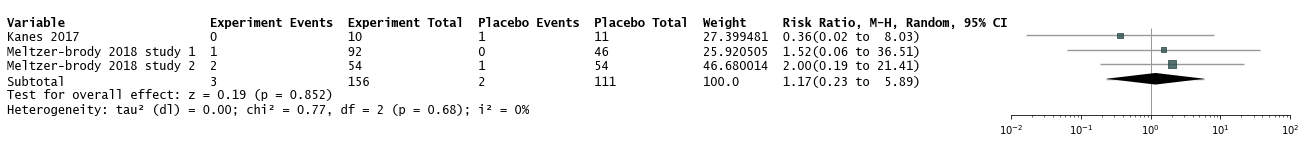

... Subgroup 3.0


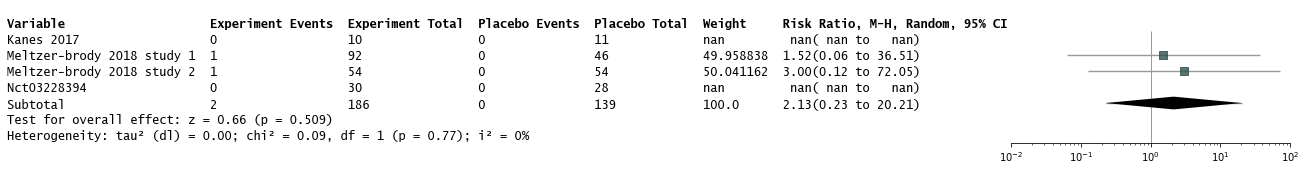

Group: 1, Analysis: 4
... Subgroup 1.0


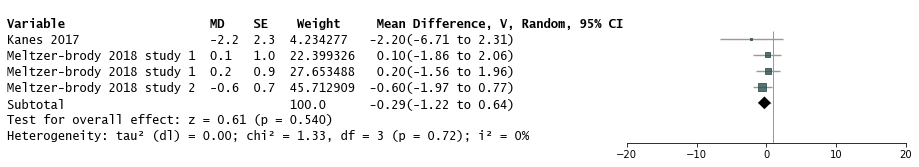

... Subgroup 2.0


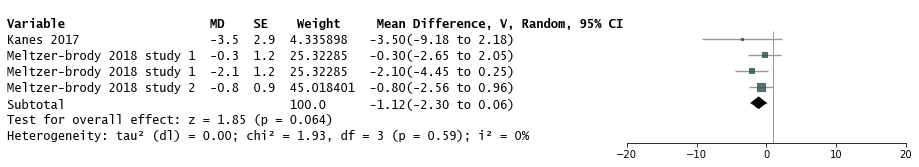

... Subgroup 3.0


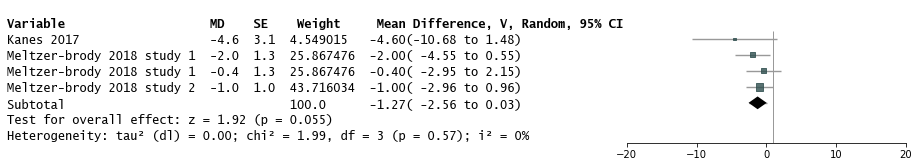

... Subgroup 4.0


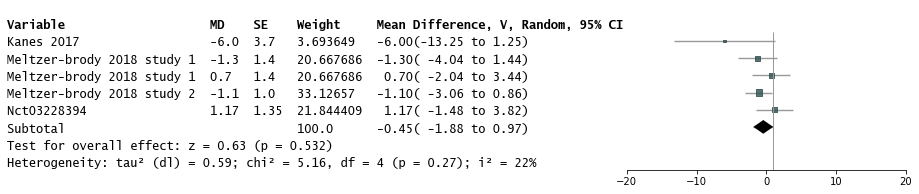

... Subgroup 5.0


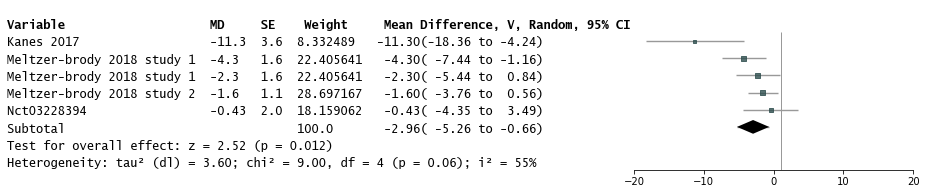

... Subgroup 6.0


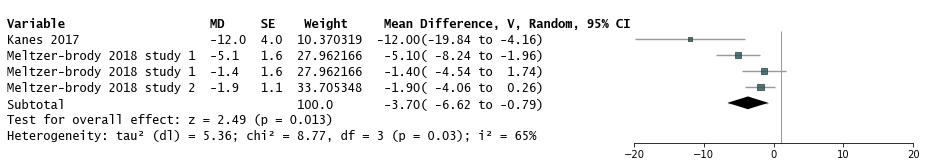

... Subgroup 7.0


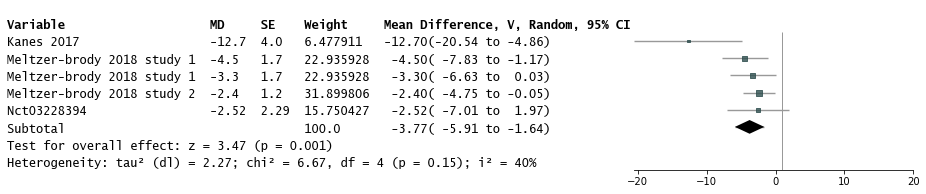

... Subgroup 8.0


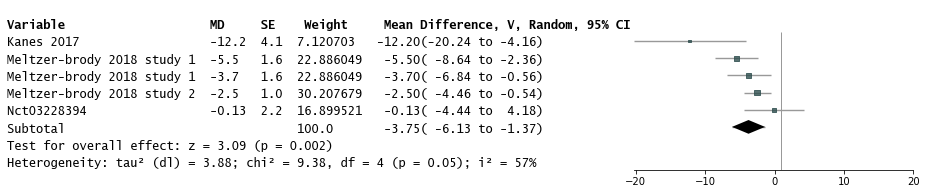

... Subgroup 9.0


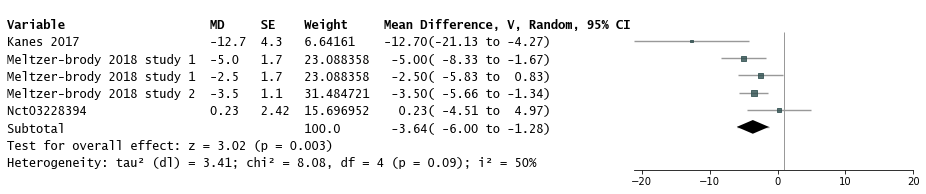

... Subgroup 10.0


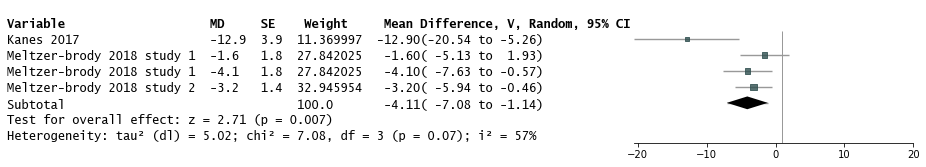

... Subgroup 11.0


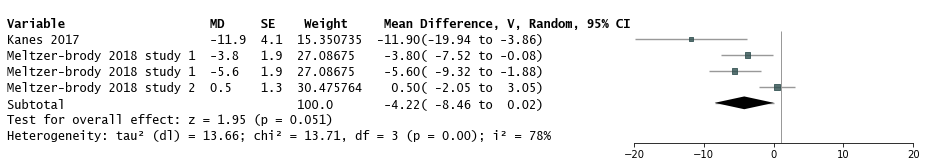

Group: 1, Analysis: 5
... Subgroup 0


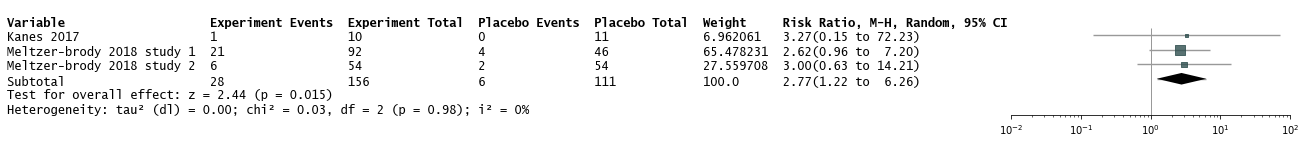

TypeError: 'int' object is not subscriptable

In [66]:
# try to create forest plots for each analysis, if there are sub-groups in an analysis, plot each subgroup
for ag in df["Analysis group"].unique():
    ag_df = df[(df["Analysis group"]==ag)]
    for an in ag_df["Analysis number"].unique():
        an_df = ag_df[ag_df["Analysis number"]==an].reset_index(drop=True)
        print(f"Group: {ag}, Analysis: {an}")
        stats_method = est[(est["Analysis group"]==ag)&(est["Analysis number"]==an)].reset_index().loc[0,"Statistical method"]
        if an_df["Subgroup"].isna().all():
            an_df["Subgroup"] = ""
            an_df["Subgroup number"] = 0
        
        for sg in an_df["Subgroup number"].unique():
            print("... Subgroup "+str(sg))
            sg_df = an_df[an_df["Subgroup number"]==sg].reset_index(drop=True)
            sg_name = sg_df["Subgroup"].unique()[0]
            sg_df["Is_total"] = 0
            sg_df["Is_total_stats"] = 0
            figsize = (5, 0.5*sg_df.shape[0]+0.5)
            if sg==0:
                # meaning actually no subgroup, pull data from the overall estimates file
                # no subgroup
                # print("No subgroup, pull the estimation")
                est_stats = est[(est["Analysis group"]==ag)&(est["Analysis number"]==an)][common_cols].reset_index(drop=True)
            if sg!=0:
                # pull data from subgroup estimates
                est_stats = est_g[(est_g["Analysis group"]==ag)&(est_g["Analysis number"]==an)&(est_g["Subgroup number"]==sg)][common_cols].reset_index(drop=True)
            
            if est_stats.shape[0]>1:
                print("!! Something's not quite right !!")

            # add an empty column to fill in estimation info necessary for the plot
            sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
            sg_df.loc[len(sg_df)-1, "Weight"] = 100
            sg_df.loc[len(sg_df)-1, "Study"] = "Subtotal"
            sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
            sg_df.loc[len(sg_df)-1, "Is_total"] = 1
            sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 0
            for col in ["Mean", "CI start", "CI end"]:
                    sg_df.loc[len(sg_df)-1, col] = est_stats.loc[0,col]

           
            # Now we've collected all the data we need, time to consider how to plot it.
            # Configurations of the plots can be different depending on the stats method used.
            # Should check out Cochrane manual for all available stats methods, other than MH and IV.
            # There seem to be "Peto/O-E" (are they the same thing?), and also a "DerSimonian and Laird"
            # (https://documentation.cochrane.org/revman-kb/files/210600101/210600103/1/1654774257333/Statistical_methods_in_revman.pdf)
            # First, let's try the forestplot library.
            if stats_method=="MH":
                annote = ["Experimental cases", "Experimental N",  "Control cases", "Control N",  "Weight", "est_ci"]
                annoteheaders = ["Experiment Events", "Experiment Total", "Placebo Events", "Placebo Total", "Weight", "Risk Ratio, M-H, Random, 95% CI"]
                # fill in the estimation data
                for col in annote[:-2]:
                    sg_df.loc[len(sg_df)-1, col] = int(est_stats.loc[0,col])
                logscale = True
                xticks = [0.01, 0.1, 1, 10, 100] # xticks have to be dynamically determined from the data, will consider this later!
            if stats_method=="IV":
                annote = ["GIV Mean", "GIV SE", "Weight", "est_ci"]
                annoteheaders = ["MD", "SE", "Weight", "Mean Difference, V, Random, 95% CI"]
                # fill in the estimation data
                
                sg_df.loc[len(sg_df)-1, "GIV Mean"] = ""
                sg_df.loc[len(sg_df)-1, "GIV SE"] = ""
                logscale = False
                xticks = [-20, -10, 0, 10, 20] # xticks have to be dynamically determined from the data, will consider this later!

            # add rows to contain info regarding subtotal stats
            # row 1: Test for total effect
            sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
            sg_df.loc[len(sg_df)-1, "Weight"] = 0
            sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
            sg_df.loc[len(sg_df)-1, "Is_total"] = 0
            sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 1
            effect_z = est_stats.loc[0, "Effect Z"]
            effect_p = est_stats.loc[0, "Effect P"]
            sg_df.loc[len(sg_df)-1, "Study"] = f"Test for overall effect: Z = {effect_z:.2f} (P = {effect_p:.3f})"

            # row 2: Heterogeneity
            sg_df.loc[len(sg_df)] = [None]*len(sg_df.columns)
            sg_df.loc[len(sg_df)-1, "Weight"] = 0
            sg_df.loc[len(sg_df)-1, "Subgroup"] = sg_name
            sg_df.loc[len(sg_df)-1, "Is_total"] = 0
            sg_df.loc[len(sg_df)-1, "Is_total_stats"] = 1
            tau = est_stats.loc[0, "Heterogeneity Tau²"]
            chi = est_stats.loc[0, "Heterogeneity Chi²"]
            df = int(est_stats.loc[0, "Heterogeneity df"])
            het_p = est_stats.loc[0, "Heterogeneity P"]
            het_i = int(est_stats.loc[0, "Heterogeneity I²"])
            sg_df.loc[len(sg_df)-1, "Study"] = f"Heterogeneity: Tau² (DL) = {tau:.2f}; Chi² = {chi:.2f}, df = {df} (P = {het_p:.2f}); I² = {het_i}%"

            # print(sg_df)
            # try:
            fp.forestplot(sg_df, estimate="Mean", ll="CI start", hl="CI end", capitalize="capitalize", varlabel="Study",
                  annote=annote, annoteheaders=annoteheaders, logscale=logscale, xticks=xticks, figsize=figsize,
                  weight_col="Weight", contains_total=True, total_col="Is_total", total_stats_col="Is_total_stats",
                  **{"xline":1,
                     "xlinecolor":"#999999"
                    }
                 )
            # figure height should be proportional to the number of rows involved in the data
            plt.show()
            # except:
            #     print(f"There's a problem with Group {ag}, Analysis {an}, Subgroup {sg}")
            # we don't to set "groupvar" if we're plotting one forest plot per sub-group
            # TODO: modify the library to handle the case of "Not estimable" (e.g., CD014624 analysis 2-5)
            # ------ 250714: DONE?
            
        
        
        

     n         r          CI95%     p-val   BF10  power       var    hl    ll  \
0  706  0.090373    [0.02 0.16]  0.016309  0.839   0.67       age  0.16  0.02   
1  706  0.048081  [-0.03  0.12]  0.201948  0.106   0.25  clerical  0.12 -0.03   
2  706  0.041229  [-0.03  0.11]  0.273948  0.086   0.19  construc  0.11 -0.03   

    moerror       group                      label  
0  0.069627         age                   in years  
1  0.071919  occupation      =1 if clerical worker  
2  0.068771  occupation  =1 if construction worker  


<Axes: xlabel='Pearson correlation', ylabel='Confidence interval'>

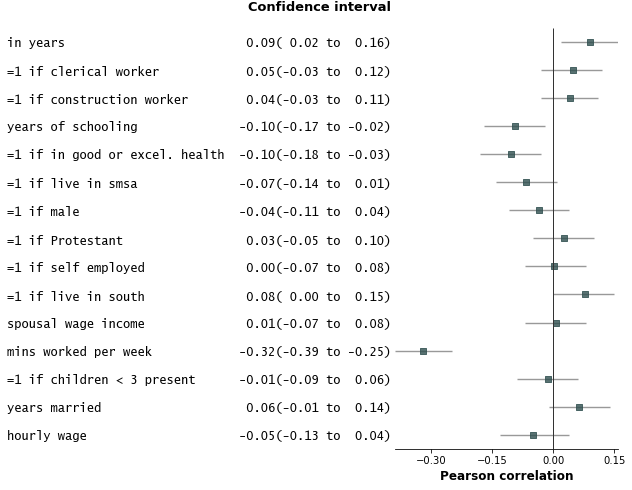

In [5]:
df = fp.load_data("sleep")
print(df.head(3))
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Pearson correlation",  # x-label title
              )

# another example to use the forestplot library:
# fp.forestplot(an_df, estimate="Mean", ll="CI start", hl="CI end", capitalize="capitalize", varlabel="Study", groupvar="Subgroup",
#               annote=["Experimental cases", "Experimental N",  "Control cases", "Control N",  "Weight", "est_ci"], 
#               annoteheaders=["Experiment events", "Experiment total", "Placebo events", "Placebo total", "Weight", "Est. (95% Conf.Int.)"],
#               logscale=True, xticks=[0.01, 0.1, 1, 10, 100], figsize=(10,20),
#               **{"xline":1,
#                  "xlinecolor":"#999999"
#                 }
#              )
# Do we really need this library if all we need is horizontal bar graphs/line segments + the total diamond?